In [1]:
import sys
sys.path.append('..')

from dataset_generators import empirical_distributions
from src.sinkhorn import sinkhorn_knopp, sinkhorn_stabilized, sinkhorn_epsilon_scaling
from src.da import SinkhornTransport, ColorClusterTransport
from utils import clustering
import transport_plan_visualisation

import matplotlib.pyplot as plt
import numpy as np
import cv2

# Simple test for 2d transporting

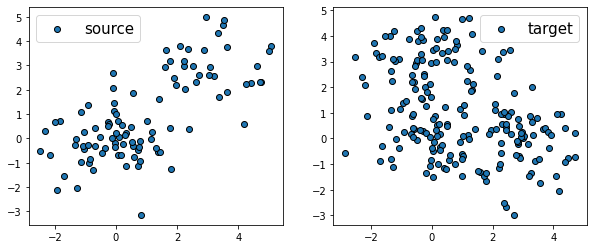

In [9]:
data_source = empirical_distributions.make_blobs(
    100, [2/3, 1/3], 
    [np.array([0,0]), np.array([3,3])],
    [np.array([[1,0], [0, 1]]), np.array([[1,0], [0, 1]])]
)

data_target = empirical_distributions.make_blobs(
    200, [1/3, 1/3, 1/3], 
    [np.array([3,0]), np.array([0,3]), np.array([0,0])],
    [np.array([[1,0], [0, 1]]), np.array([[1,0], [0, 1]]), np.array([[1,0], [0, 1]])]
)

_, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[1].scatter(data_target[:, 0], data_target[:, 1], 
              label='target', edgecolors='black')
ax[1].legend(fontsize=15)
ax[0].scatter(data_source[:, 0], data_source[:, 1], 
              label='source', edgecolors='black')
_ = ax[0].legend(fontsize=15)

In [10]:
vanilla_transport = SinkhornTransport(sinkhorn_knopp,
                                      {'reg': 1e-1, 'max_iter':1e2})

In [11]:
xt_vanilla = vanilla_transport.fit_transform(data_source, data_target)

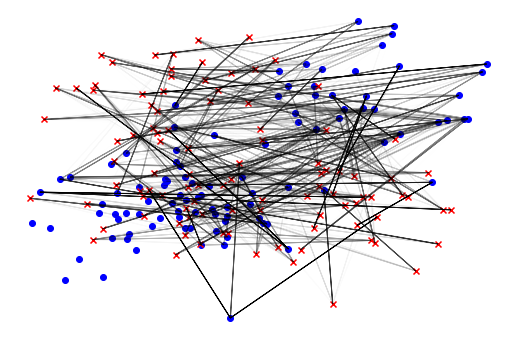

In [12]:
# transport graph
transport_plan_visualisation.plot_transportation_2d(data_source, 
                                                    xt_vanilla, 
                                                    vanilla_transport.ot_matrix)

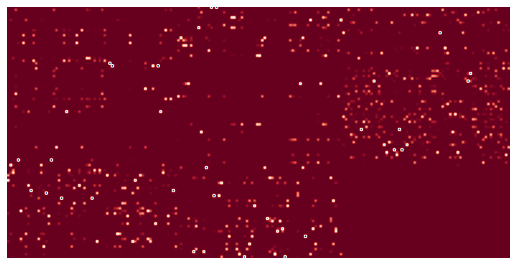

In [13]:
# transport plan matrix
transport_plan_visualisation.imshow_transportation(vanilla_transport.ot_matrix)

# Measuring time

In [40]:
times = []
for N in np.logspace(1, 3, 5, dtype=np.int64):
    data_source = empirical_distributions.make_blobs(
                    N, [2/3, 1/3], 
                    [np.array([0,0]), np.array([3,3])],
                    [np.array([[1,0], [0, 1]]), np.array([[1,0], [0, 1]])]
                    )
    data_target = empirical_distributions.make_blobs(
                    N, [1/3, 1/3, 1/3], 
                    [np.array([3,0]), np.array([0,3]), np.array([0,0])],
                    [np.array([[1,0], [0, 1]]), np.array([[1,0], [0, 1]]), np.array([[1,0], [0, 1]])]
                    )
    source_distr = np.ones(data_source.shape[0])
    source_distr[:(N//3 * 2)] = 2
    source_distr = source_distr / np.linalg.norm(source_distr)**2
    
    eps_transport = SinkhornTransport(sinkhorn_epsilon_scaling,
                                      {'eps_fn': lambda x: 10**(-x),
                                       'verbose': True})
    eps_transport.fit(data_source, data_target, 
                      distr_xs=source_distr, 
                      distr_xt=np.ones(data_target.shape[0]) / data_target.shape[0])
    times.append(eps_transport.fitting_time)
    print(N)

iteration     0	err1.481481e-01
iteration    10	err1.481481e-01
iteration    20	err4.705504e-01
iteration    30	err4.705504e-01
iteration    40	err4.705504e-01
iteration    50	err4.705504e-01
iteration    60	err4.705504e-01
iteration    70	err4.705504e-01
iteration    80	err4.705504e-01
iteration    90	err4.705504e-01
iteration   100	err4.705504e-01
10
iteration     0	err8.114408e-02
iteration    10	err8.137201e-02
iteration    20	err8.302412e-02
iteration    30	err8.302412e-02
iteration    40	err8.302412e-02
iteration    50	err8.302412e-02
iteration    60	err8.302412e-02
iteration    70	err8.302412e-02
iteration    80	err8.302412e-02
iteration    90	err8.302412e-02
iteration   100	err8.302412e-02
31
iteration     0	err4.466835e-02
iteration    10	err4.479086e-02
iteration    20	err4.601300e-02
iteration    30	err4.601300e-02
iteration    40	err4.601300e-02
iteration    50	err4.601300e-02
iteration    60	err4.601300e-02
iteration    70	err4.601300e-02
iteration    80	err4.601300e-02
it

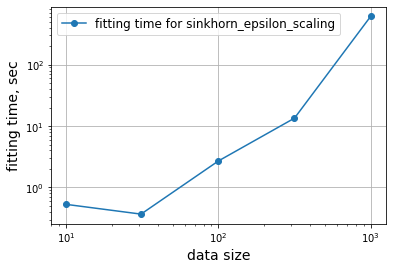

In [45]:
plt.loglog(np.logspace(1, 3, 5, dtype=np.int64),
           np.abs(times), label='fitting time for sinkhorn_epsilon_scaling',
           marker='o')
plt.xlabel('data size', fontsize=14)
plt.ylabel('fitting time, sec', fontsize=14)
plt.grid()
_ = plt.legend(fontsize=12)

# Color transfering via clusterization

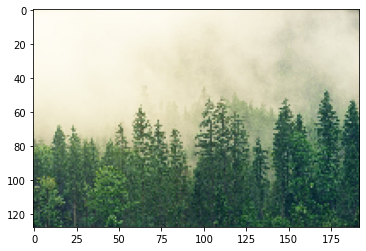

In [2]:
im1 = cv2.cvtColor(cv2.imread('../images/forest.jpg'), cv2.COLOR_BGR2RGB)
im1 = cv2.resize(im1, (192, 128))
plt.imshow(im1)

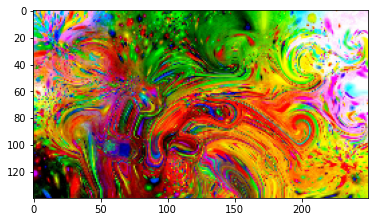

In [3]:
im2 = cv2.cvtColor(cv2.imread('../images/lcd.jpg'), cv2.COLOR_BGR2RGB)
im2 = cv2.resize(im2, (250, 140))
plt.imshow(im2)

In [4]:
vanilla_Ctransport = ColorClusterTransport(sinkhorn_knopp,
                                          {'reg': 1, 'max_iter':1e2},
                                          200, metric='euclidean')

In [5]:
im1_transported = vanilla_Ctransport.fit_transform(im1, im2, clustering.KMeans_clustering)

In [6]:
print(f'Clusterization time: {vanilla_Ctransport.clusterization_time}')
print(f'Fitting time: {vanilla_Ctransport.fitting_time}')

Clusterization time: 71.93195962905884
Fitting time: 0.03807687759399414


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


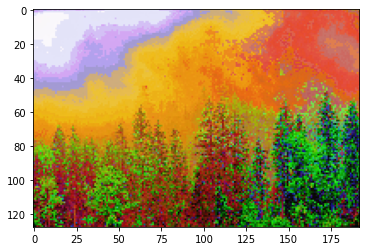

In [7]:
plt.imshow(im1_transported)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


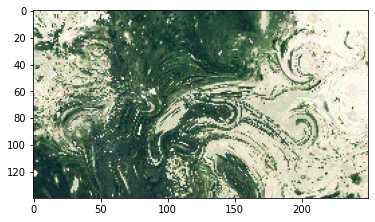

In [8]:
plt.imshow(vanilla_Ctransport.inverse_transform(im2))